In [1]:
from pyspark.sql import SQLContext
from pyspark.sql import functions as sf
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import DateType
from datetime import date, timedelta
import datetime as dt
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.regression import RandomForestRegressionModel,RandomForestRegressor
from pyspark.sql.functions import col, avg, sum
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import pandas as pd
import pyspark
from collections import Counter

In [3]:
sc.stop()
sc = pyspark.SparkContext(master="spark://172.16.27.208:7077",appName="spark")
sc

<SparkContext master=spark://172.16.27.208:7077 appName=spark>

In [4]:
base_path = "/home/test5/Desktop/smart-meters-in-london/"
sqlcontext = SQLContext(sc)

In [5]:
cluster_feature = sqlcontext.read.csv(path=base_path+"bk=8_means_Feature.csv",header=True,inferSchema=True)
# cluster_feature = cluster_feature.drop("_c0","date2")
# cluster_feature = cluster_feature.withColumn("windSpeed",cluster_feature["windSpeed"].cast("float"))
# cluster_feature = cluster_feature.withColumn("dewPoint",cluster_feature["dewPoint"].cast("float"))
cluster_feature.printSchema()
type(cluster_feature)

root
 |-- _c0: integer (nullable = true)
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- month: integer (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (

pyspark.sql.dataframe.DataFrame

In [6]:
cluster_feature = cluster_feature.withColumn("holiday1",sf.when((col("Weekday/end")==1) | (col("holiday")==1),1).otherwise(0))
cluster_feature = cluster_feature.drop("_c0","diff_energy_week_t_1","date2","holiday","month","Weekday/end")
cluster_feature = cluster_feature.withColumnRenamed("holiday1","holiday")
cluster_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, rnk=32, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3

In [7]:
outputCols = ["weekDay_index","precipType_index","summary_index"]
df_encoded = cluster_feature
df_encoded = df_encoded.na.drop()
for col in outputCols: 
    encoder = OneHotEncoder(inputCol=col, outputCol="category_{}".format(col))
    df_encoded = encoder.transform(df_encoded).cache()
df_encoded = df_encoded.drop("rnk")
df_encoded.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- hour: integer (nullable = true)
 |-- energy(kWh/h): double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_d

In [8]:
inputCols = ["weekDay","precipType","summary",]
columns = df_encoded.columns
feature_col = columns[4:]
feature_col.append(columns[2])
feature_col = set(feature_col) - set(inputCols)
feature_col = feature_col - set(outputCols)
feature_col = list(feature_col)
df_encoded = df_encoded.na.drop()
len(feature_col)

vecAssembler = VectorAssembler(inputCols=feature_col, outputCol="features")
df_feature = vecAssembler.transform(df_encoded)
df_feature.take(1)

[Row(cluster_id=1, date=datetime.datetime(2013, 1, 1, 0, 0), hour=0, energy(kWh/h)=265.413, weekDay='Tue', 1_diff_energy_t_0=230.108, 2_diff_energy_t_0=242.838, 3_diff_energy_t_0=239.363, 4_diff_energy_t_0=231.928, 5_diff_energy_t_0=230.906, 6_diff_energy_t_0=236.636, 7_diff_energy_t_0=235.955, 1_diff_energy_t_1=278.6, 2_diff_energy_t_1=282.455, 3_diff_energy_t_1=289.14, 4_diff_energy_t_1=281.541, 5_diff_energy_t_1=268.213, 6_diff_energy_t_1=272.572, 7_diff_energy_t_1=277.427, 1_diff_energy_t_2=346.241, 2_diff_energy_t_2=334.529, 3_diff_energy_t_2=342.058, 4_diff_energy_t_2=342.666, 5_diff_energy_t_2=326.166, 6_diff_energy_t_2=304.912, 7_diff_energy_t_2=333.314, diff_energy_week_t_2=217.882, diff_energy_week_t_3=218.23, diff_energy_week_t_4=212.166, mean_1=283.6334583333333, mean_2=283.55745833333333, mean_3=283.9150833333333, mean_4=279.71179166666667, mean_5=276.9005, mean_6=269.6797916666667, mean_7=286.57225, min_1=136.298, max_1=468.535, min_2=133.018, max_2=438.373, min_3=130.779

In [9]:
df_feature = df_feature.withColumnRenamed("energy(kWh/h)","label")
df_feature = df_feature.withColumn("date",df_feature["date"].cast(DateType()))
df_feature.printSchema()

root
 |-- cluster_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- weekDay: string (nullable = true)
 |-- 1_diff_energy_t_0: double (nullable = true)
 |-- 2_diff_energy_t_0: double (nullable = true)
 |-- 3_diff_energy_t_0: double (nullable = true)
 |-- 4_diff_energy_t_0: double (nullable = true)
 |-- 5_diff_energy_t_0: double (nullable = true)
 |-- 6_diff_energy_t_0: double (nullable = true)
 |-- 7_diff_energy_t_0: double (nullable = true)
 |-- 1_diff_energy_t_1: double (nullable = true)
 |-- 2_diff_energy_t_1: double (nullable = true)
 |-- 3_diff_energy_t_1: double (nullable = true)
 |-- 4_diff_energy_t_1: double (nullable = true)
 |-- 5_diff_energy_t_1: double (nullable = true)
 |-- 6_diff_energy_t_1: double (nullable = true)
 |-- 7_diff_energy_t_1: double (nullable = true)
 |-- 1_diff_energy_t_2: double (nullable = true)
 |-- 2_diff_energy_t_2: double (nullable = true)
 |-- 3_diff_energy_t_

In [10]:
def get_aggregate(df):
    list = ["date","hour"]
    df = df.groupBy(list).agg(sum("label"),sum("prediction"))    
    return df
def select_predicted_actual(df,date,LCLid=None):
    list = []
    if LCLid != None:
        list = df.where((df["LCLid"] == LCLid) & (df["date"] == date)).select("label","prediction").collect()
    else:
        list = df.where((df["date"] == date)).select("label","prediction").collect()
    actual = [int(row['label']) for row in list]
    predicted = [int(row['prediction']) for row in list]
    return actual,predicted

def populate_precision_recall(actual,predicted,precision,recall,predicted_peak_period,actual_peak_period):
    actual, predicted = np.array(actual),np.array(predicted)
    actual_std, predicted_std = np.std(actual), np.std(predicted)
    actual_mean, predicted_mean = np.mean(actual),np.mean(predicted)
    actual_threshhold, predicted_threshhold = actual_std + actual_mean,predicted_std+predicted_mean
    
    y_label, y_predicted = [],[]
    for power,power1 in zip(actual,predicted):
        y_label.append(1) if power > actual_threshhold else y_label.append(0)
        y_predicted.append(1) if power1 > predicted_threshhold else y_predicted.append(0)
    
    predicted_peak_period.append(y_predicted)
    actual_peak_period.append(y_label)
    
    counts = Counter(zip(y_predicted,y_label))
    tp = counts[1,1]
    fp = counts[1,0]
    tn = counts[0,0]
    fn = counts[0,1]
    
    recall.append((tp/float(tp+fn)) if tp+fn else 0)
    precision.append((tp+tn)/24.0)
    return precision,recall, predicted_peak_period,actual_peak_period

In [11]:
train_df_cluster = []
test_df_cluster = []
num_of_cluster = 8
for cluster_id in range(num_of_cluster):
    train_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] <= date(2013,10,31)))
    test_df = df_feature.where((df_feature["cluster_id"] == cluster_id) & (df_feature["date"] > date(2013,10,31)))# & (df_feature["date"] <= date(2013,1,2)))
    print("Train_point = {}, Test_point = {}, cId = {}".format(train_df.count(),test_df.count(),cluster_id))
    train_df_cluster.append(train_df)
    test_df_cluster.append(test_df)

Train_point = 7288, Test_point = 1464, cId = 0
Train_point = 7288, Test_point = 1464, cId = 1
Train_point = 7288, Test_point = 1464, cId = 2
Train_point = 7288, Test_point = 1464, cId = 3
Train_point = 7288, Test_point = 1464, cId = 4
Train_point = 7288, Test_point = 1464, cId = 5
Train_point = 7288, Test_point = 1464, cId = 6
Train_point = 7288, Test_point = 1464, cId = 7


In [12]:
pred_val = []
flag = 0
for cluster_id in range(num_of_cluster):
    rf = RandomForestRegressor(numTrees=20,maxDepth=10,maxBins=128,seed=4)
    model = rf.fit(train_df_cluster[cluster_id])
#     model.save(base_path+"/Model/rf_bkm/rf_model_bkm_{}".format(cluster_id))
    rf_pred_val = model.transform(test_df_cluster[cluster_id])
    if flag == 0:
        pred_val = sqlcontext.createDataFrame([],rf_pred_val.schema)
        flag = 1
    pred_val = pred_val.union(rf_pred_val)
    pred_val = pred_val.cache()

In [13]:
aggregate_df = get_aggregate(pred_val)
aggregate_df = aggregate_df.withColumnRenamed("sum(label)","label")
aggregate_df = aggregate_df.withColumnRenamed("sum(prediction)","prediction")

In [66]:
train_start_date = date(2013,12,31)
train_end_date = date(2013,12,31)
y_date = []
predicted_peak_period = []
actual_peak_period = []
precision = []
recall = [] 
while train_start_date <= train_end_date:
    print(train_start_date)
    y_actual,y_pred = select_predicted_actual(aggregate_df,train_start_date)
    if len(y_actual) == 0:
        train_start_date = train_start_date + timedelta(1)
        continue
    precision,recall,predicted_peak_period,actual_peak_period = populate_precision_recall(y_actual,y_pred,precision,recall,predicted_peak_period,actual_peak_period)
    y_date.append(train_start_date)
    train_start_date = train_start_date + timedelta(1)

2013-12-31


In [67]:
y_actual,y_pred = select_predicted_actual(aggregate_df,date(2013,12,25))
print(y_actual)
print(y_pred)
print(np.mean(np.array(y_actual)),np.std(np.array(y_actual)))
print(np.mean(np.array(y_pred)),np.std(np.array(y_pred)))

[1944, 2641, 2448, 2219, 2815, 2840, 1821, 2532, 1101, 2591, 2257, 1332, 2608, 1478, 1837, 2334, 987, 1003, 2724, 2588, 2435, 2637, 1058, 1207]
[2025, 2759, 1930, 2392, 1904, 1921, 1864, 3012, 1174, 2292, 1940, 1585, 1937, 1360, 1773, 2589, 966, 983, 1903, 2983, 2846, 1888, 1016, 1120]
2059.875 636.1624735146937
1923.4166666666667 610.943595096052


In [68]:
from statistics import mean
print("Mean accuracy = {}, Mean recall = {}".format(mean(precision),mean(recall)))

Mean accuracy = 0.9583333333333334, Mean recall = 1.0


In [72]:
actual_predicted = aggregate_df.where((aggregate_df.date==date(2013,12,31))).select("label","prediction").toPandas()

In [73]:
predicted_peak_period

[[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

[5, 9, 11, 14, 23] [5, 9, 11, 23]


Text(0, 0.5, 'Aggregated Load(Kw/h)')

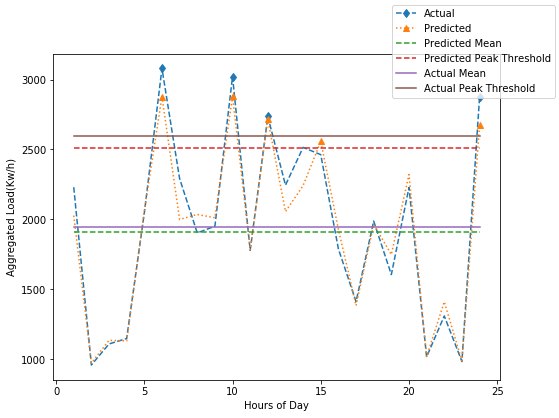

In [79]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
mark_actual,mark_predicted = [],[]
for i in range(24):
    if predicted_peak_period[0][i] == 1:
        mark_predicted.append(i)
    if actual_peak_period[0][i] == 1:
        mark_actual.append(i)
print(mark_predicted,mark_actual)
ax.plot(np.arange(1,25),actual_predicted["label"],linestyle = '--',marker="d",markevery=mark_actual, label = "Actual")
ax.plot(np.arange(1,25),actual_predicted["prediction"],linestyle = ':',marker="^",markevery=mark_predicted,label = "Predicted")
ax.plot(np.arange(1,25),[actual_predicted["prediction"].mean()]*24,linestyle='--',label="Predicted Mean")
ax.plot(np.arange(1,25),[actual_predicted["prediction"].mean()+actual_predicted["prediction"].std()]*24,linestyle='--',label = "Predicted Peak Threshold")
ax.plot(np.arange(1,25),[actual_predicted["label"].mean()]*24,linestyle='-',label = "Actual Mean")
ax.plot(np.arange(1,25),[actual_predicted["label"].mean()+actual_predicted["label"].std()]*24,linestyle='-',label = "Actual Peak Threshold")
fig.legend()
ax.set_xlabel("Hours of Day")
ax.set_ylabel("Aggregated Load(Kw/h)" )

In [80]:
fig.savefig(base_path+"/plot/peak.png",dpi=600)

In [77]:
actual_predicted["prediction"].std()

596.9613014336046

In [78]:
y_date[54]

IndexError: list index out of range

In [92]:
predicted_peak_period[54]

[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]

In [93]:
actual_peak_period[54]

[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]